<a href="https://colab.research.google.com/github/liadmagen/Modeling_course/blob/main/exercises_notebooks/02_KNN_and_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geometric aspects of data

## Introduction
In our previous assignment, we trained two types of classifiers:
- A discrete classifier, a decision tree, which chose the appropriate label from a finite set
- An continuous classifier - linear and logistic regression models that scored or ranked each of the data points.

One way to interpret those classifiers is as a **mapping function** between the data to its label, between each `X` data point to its corresponding `y`.

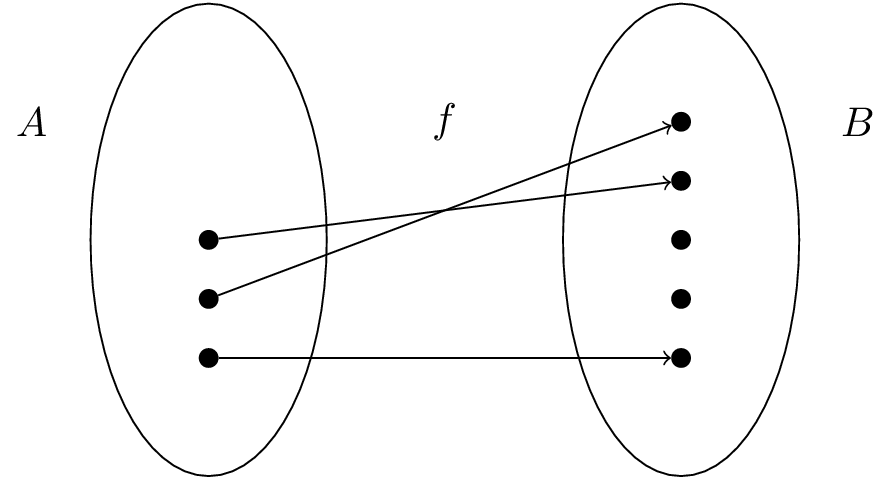

## Data as a vector

We will not always have labels for every data point. Labeling the data may be expensive. It may include hiring people for this purpose, or it may require waiting a long time to examine the results.

For example, in the case of churn prediction, we do not want to wait and test which clients leave the company. It would be better to try to predict it in advance.

Here is an idea - we can imagine our data, our features values, as a set of multi-dimensional points. Adjacent points in this multi-dimensional space may have a similar outcome. We can learn a classifier that given a new data point, will asign its label based on the labels of the other points around it.  

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In this exercise, we will work with [Telco Customer churn data from IBM](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113
).

The Telco customer churn data contains information about a fictional telco company that provided home phone and Internet services to 7043 customers in California in Q3. It indicates which customers have left, stayed, or signed up for their service. Multiple important demographics are included for each customer, as well as a Satisfaction Score, Churn Score, and Customer Lifetime Value (CLTV) index.

Hhere we will use a smaller version of it, for simplicity.

In [4]:
df = pd.read_csv('https://github.com/liadmagen/Modeling_course/raw/main/data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


we are not interested in the `CustomerID` column, and therefore we will remove it from the dataset:

In [6]:
df.drop(['customerID'], axis=1, inplace=True)

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


## Converting columns to numerical values

Previously, when handling Logistic Regression, we had to pre-process our data,  transform and scale it before using it as an input. 
In this dataset, we have a different problem: some of our features are not even numerical.

Computers can only 'understand' numerical values. Therefore, the data we feed into our models must be in a numerical form.

> How can we tackle that?

Pandas treats columns with values such as 'Yes / No' as text columns. They are represented as an 'object' type.

In [8]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

We can count how many unique values those columns contain using the method `.value_counts()`.

In [9]:
df['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

Let's take a look at all those columns which are not numerical with the `.select_dtypes()` method:

In [10]:
 df.select_dtypes(include=['object'])

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,1889.5,No
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,108.15,Yes
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),1840.75,No
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,1990.5,No
7039,Female,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),7362.9,No
7040,Female,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,346.45,No
7041,Male,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,306.6,Yes


Notice the `TotalCharges` column. This is a numerical value that was not properly parsed. Let's find out why and change it manually to numeric (float).

In [11]:
df['TotalCharges'].value_counts()

           11
20.2       11
19.75       9
20.05       8
19.9        8
           ..
77.5        1
300.8       1
218.55      1
237.2       1
6254.45     1
Name: TotalCharges, Length: 6531, dtype: int64

The column contains empty values (empty strings). We must fix it before changing the type to numeric.

How can we fix it?
1. we can remove entirely those rows
2. we can fill these values with a numerical value, such as 0.0 or negative value that would represent it to be previously an empty string.


In [12]:
### YOUR TURN: ###
# Choose one of the methods and clean the noisy data points
# Check the method `.str.strip` that removes all white spaces from the cell.
# https://pandas.pydata.org/docs/reference/api/pandas.Series.str.strip.html






##################

Now with the column cleaned, we are ready to convert it to numerical value:

In [13]:
df['TotalCharges'] = df['TotalCharges'].astype('float')

We will convert the rest of the columns to a `categorical` type, a data type in pandas, made for columns with a limited amount of unique values. It assigns each category a numerical value.

Read more about pandas categorical values here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html

In [14]:
# first we store the original as a copy:
df_original = df.copy()

# Then we convert all our categories to numerical values:
for col in  df.select_dtypes(include=['object']).columns:
  df[col] = df[col].astype('category')
  df[col] = df[col].cat.codes

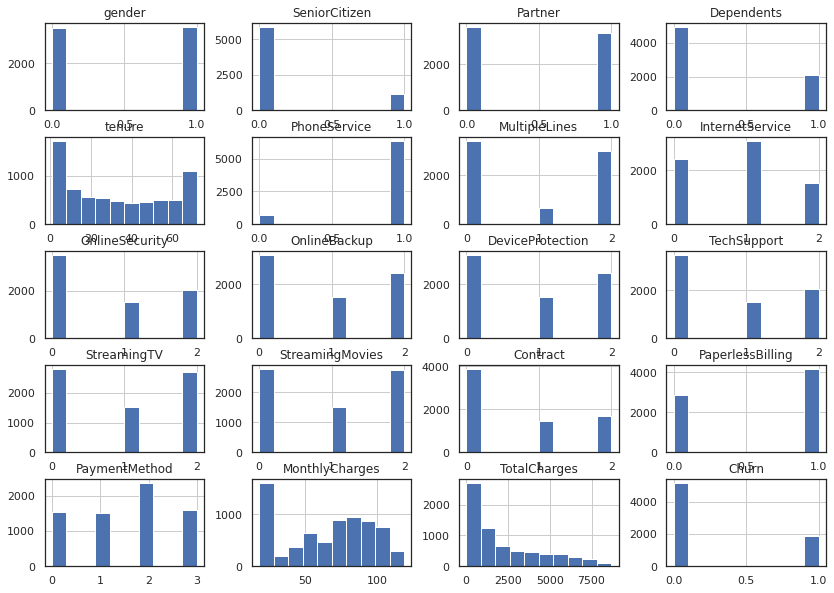

In [15]:
hists = df.hist()

Let's look at some random row as an example:

In [16]:
df.iloc[1234]

gender                 0.00
SeniorCitizen          1.00
Partner                0.00
Dependents             0.00
tenure                16.00
PhoneService           1.00
MultipleLines          2.00
InternetService        1.00
OnlineSecurity         0.00
OnlineBackup           0.00
DeviceProtection       0.00
TechSupport            0.00
StreamingTV            2.00
StreamingMovies        2.00
Contract               0.00
PaperlessBilling       1.00
PaymentMethod          2.00
MonthlyCharges        96.15
TotalCharges        1529.20
Churn                  1.00
Name: 1238, dtype: float64

Now we are ready. Our data is numeric. 

# Vector Distance and KNN

Our data now exists in a numerical form. The advantage of having the data as numeric is that we can use a distance metric to calculate how near every point is to the rest of the points in the multi-dimensional space. 

We hope, through it, to get a notion of how similar those points are to each other.

For example, these two data points are relatively similar. Hence we hope they would have the same Churn output.

| Column             | Point 1 | Point 2 |
|--------------------|---------|---------|
| gender             |    0.00 |    1.00 |
| SeniorCitizen      |    1.00 |    1.00 |
| Partner            |    0.00 |    0.00 |
| Dependents         |    0.00 |    0.00 |
| tenure             |   16.00 |   15.00 |
| PhoneService       |    1.00 |    1.00 |
| MultipleLines      |    2.00 |    2.00 |
| InternetService    |    1.00 |    1.00 |
| OnlineSecurity     |    0.00 |    0.00 |
| OnlineBackup       |    0.00 |    0.00 |
| DeviceProtection   |    0.00 |    0.00 |
| TechSupport        |    0.00 |    0.00 |
| StreamingTV        |    2.00 |    2.00 |
| StreamingMovies    |    2.00 |    2.00 |
| Contract           |    0.00 |    0.00 |
| PaperlessBilling   |    1.00 |    1.00 |
| PaymentMethod      |    2.00 |    2.00 |
| MonthlyCharges     |   96.15 |   94.11 |
| TotalCharges       | 1529.20 | 1519.35 |

## How is the distance calculated?
One of the simplest method is the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance). For two simple 2D values, e.g., **(2,3)** & **(5,1)**, that would be: $\sqrt{(2-5)^2+(3-1)^2}$

For multiple dimensions, we can use the generalized formula:

$$ d(a, b) = \sqrt{\sum_{i=1}^D (a_i - b_i)^2 } $$


Now, that we have a way to measure how two different points in the space relate to each other, let's think how we can learn 

## K-Nearest Neighbors

The basic notion is this: Adjacent points in this multi-dimensional space should have a similar outcome. 

We can learn a classifier that given a new data point, will calculte the distance to the other points, and asign its label based on the labels of the `k` nearest points to it.

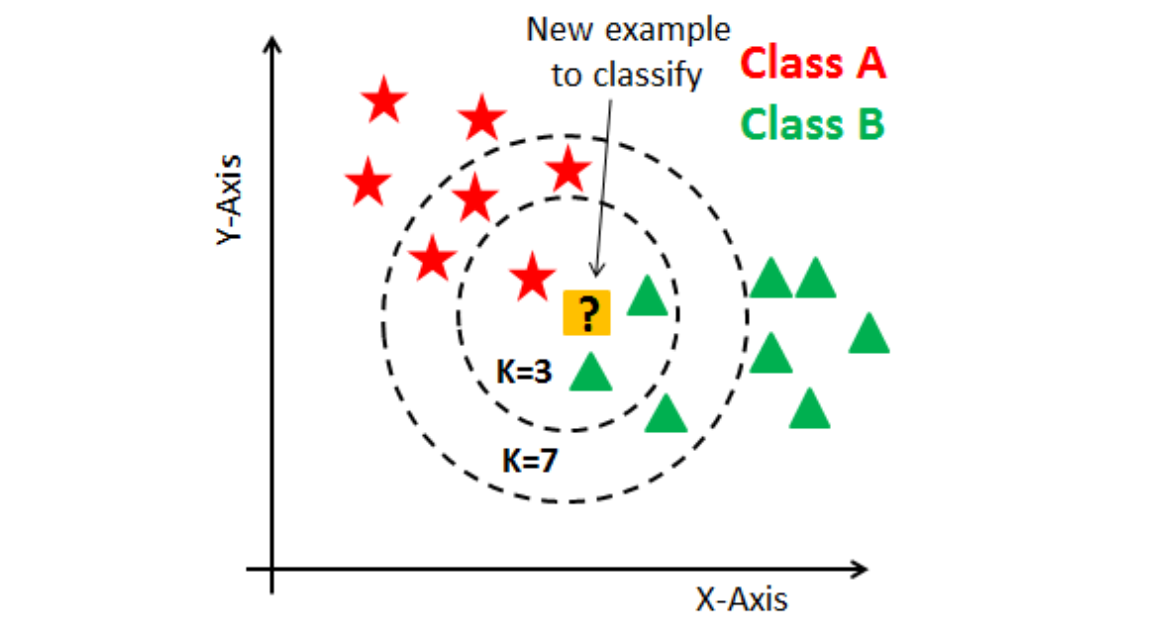

In [19]:
from sklearn.neighbors import KNeighborsClassifier

Let's separate first the data to **train** and **test** sets

In [20]:
#### Your Turn: ####
# Separate the data to training and testing set, as we did in the previous exercise







####

And create the K-Nearest Neighbors classifier with our data:


In [21]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)


KNeighborsClassifier()

As before, we can calculate how well our model performs on the test data:

In [22]:
from sklearn import metrics

print(metrics.classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1711
           1       0.59      0.45      0.51       610

    accuracy                           0.77      2321
   macro avg       0.70      0.67      0.68      2321
weighted avg       0.76      0.77      0.76      2321



The default number of neighbors of the [classifier](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification
) is `5`.

The [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) has a `hyperparameter` called `n_neighbors` which controls the number of neighbors we compare the new point to.

Let's try creating it again using an even number of neighbors - say `4` or `6`:

In [28]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

print(metrics.classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      1711
           1       0.64      0.38      0.48       610

    accuracy                           0.78      2321
   macro avg       0.72      0.65      0.67      2321
weighted avg       0.76      0.78      0.76      2321



If we print the probabilities, we can see that since we used an even number of neighbors, for some of the test points KNN is not sure anymore:

In [29]:
knn.predict_proba(X_test)[:20]

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.33333333, 0.66666667],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.66666667, 0.33333333],
       [0.83333333, 0.16666667],
       [0.66666667, 0.33333333],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.33333333, 0.66666667],
       [0.5       , 0.5       ],
       [1.        , 0.        ],
       [0.66666667, 0.33333333],
       [1.        , 0.        ],
       [0.5       , 0.5       ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.83333333, 0.16666667],
       [1.        , 0.        ]])

In [30]:
# Let's count how many points:
prediction_probabilities = knn.predict_proba(X_test)[:, 0]

# we use here the NumPy package - NUMerical PYthon - which has many strong 
# methods to manipulate and search in numerical vectors
np.argwhere(prediction_probabilities == 0.5).shape[0] / len(X_test)

0.1055579491598449

This uncertainty is important. 

When we need to make decisions based on the data, we need ot know for which values we are sure vs for which we have low certainty.

Let's calculate the metrics only for the part of the data which we are sure about.


In [31]:
# get the indeces of the values we are sure about
sure_indeces = np.argwhere(prediction_probabilities != 0.5).squeeze()

# and print the classification report again:
print(metrics.classification_report(y_test.iloc[sure_indeces], knn.predict(X_test.iloc[sure_indeces])))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1569
           1       0.64      0.45      0.53       507

    accuracy                           0.80      2076
   macro avg       0.74      0.69      0.70      2076
weighted avg       0.79      0.80      0.79      2076



SciKit-Learn has an additional class called [RadiusNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifier).

The main difference between the `Radius` and the `K-Nearest` classifiers is that the Radius Classifier only searches within a **fixed distance** around a new point. 

Feel free to give it a try on our train and test data.
Print the classification report and compare it to the K-NN

In [26]:
#### Try the RadiusNeighborsClassifier with different radius sizes: ####








####################################################

# Decision Boundaries

Let's visualize the data by projecting it into a 2D space using PCA. You have already done it with R - now it's time to do it with python.

We deliberately remove the Churn column - to simulate the PCA output without revealing it what the result is.

In [34]:
from sklearn.decomposition import PCA

y = df['Churn']
X = df.drop('Churn', axis=1)

reduced_X = PCA(n_components=2).fit_transform(X)
reduced_X

Our data is now projected into a 2D space, so we can plot it:

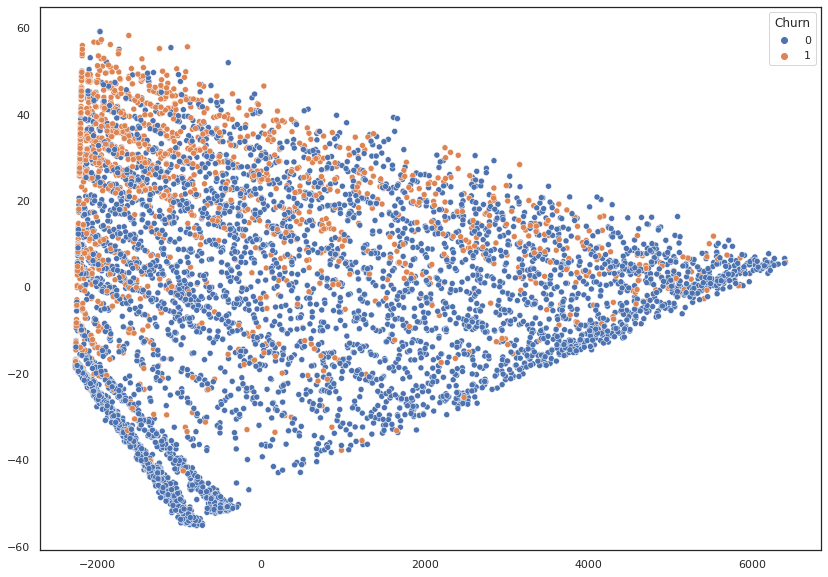

In [ ]:
sns.scatterplot(x = reduced_X[:, 0], y=reduced_X[:, 1], hue=y)

In some cases, the data may be easily separable: either linearly - with a simple boundary line, or in a more complex way, such as a very jagged line that is prone to overfitting, or maybe even a boundary in a higher dimension.

## UMAP
In R, you have also learned about T-SNE.

Here, we get to know yet another projection algorithm called [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html) - Uniformed Manifold Approximation and Projection.

Let's see how it performs when projecting our data.

In [39]:
%%capture
!pip install umap-learn

In [45]:
import umap

In [46]:
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

In [47]:
%%time
fit = umap.UMAP()
umap_reduced = fit.fit_transform(X)

CPU times: user 42.8 s, sys: 5.73 s, total: 48.6 s
Wall time: 39.8 s


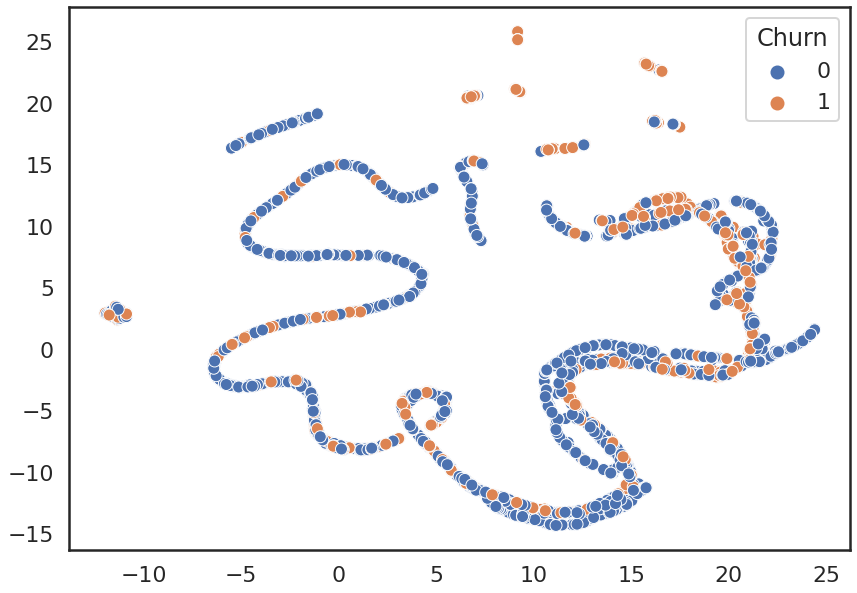

In [48]:
sns.scatterplot(x = umap_reduced[:, 0], y=umap_reduced[:, 1], hue=y)

As KNN, also UMAP has a hyperparameter - [n_neighbors](https://umap-learn.readthedocs.io/en/latest/parameters.html#n-neighbors) - that sets the number of neighbors it 'looks' at to decide the proximity between two data points.

From the UMAP website:
> With a value of n_neighbors=2 UMAP merely glues together small chains, but due to the narrow/local view, fails to see how those connect together.

> As n_neighbors is increased (n_neighbors=50) UMAP manages to see more of the overall structure of the data, gluing more components together, and better coverying the broader structure of the data. 

> As n_neighbors increases further more and more (n_neighbors=200) focus in placed on the overall structure of the data. 

CPU times: user 56.1 s, sys: 3.86 s, total: 1min
Wall time: 48.9 s


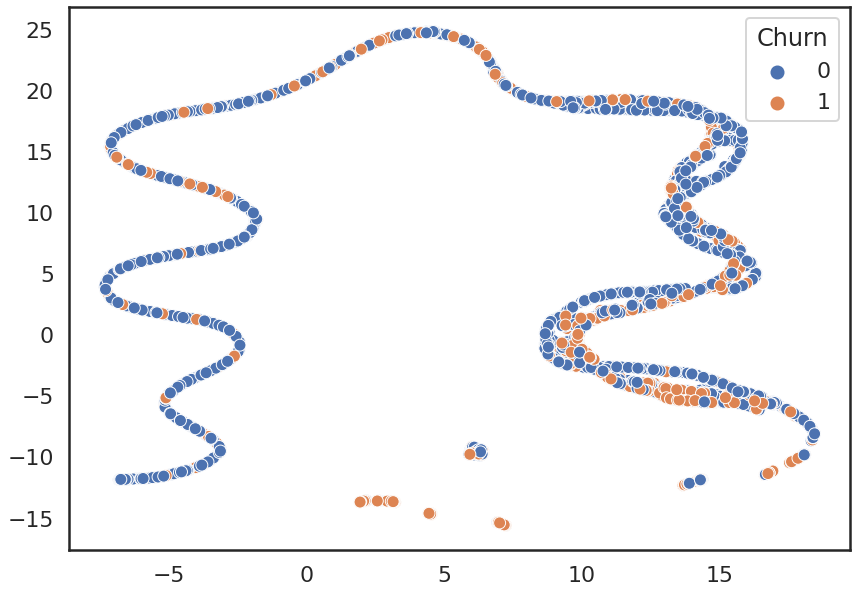

In [49]:
%%time
fit = umap.UMAP(n_neighbors=50)
umap_reduced = fit.fit_transform(X)
sns.scatterplot(x = umap_reduced[:, 0], y=umap_reduced[:, 1], hue=y)

Another interesting property of UMAP is the [metric](https://umap-learn.readthedocs.io/en/latest/parameters.html#metric) used to calculate the distances between the points.

UMAP supports a large variety of metrics for different types of data.

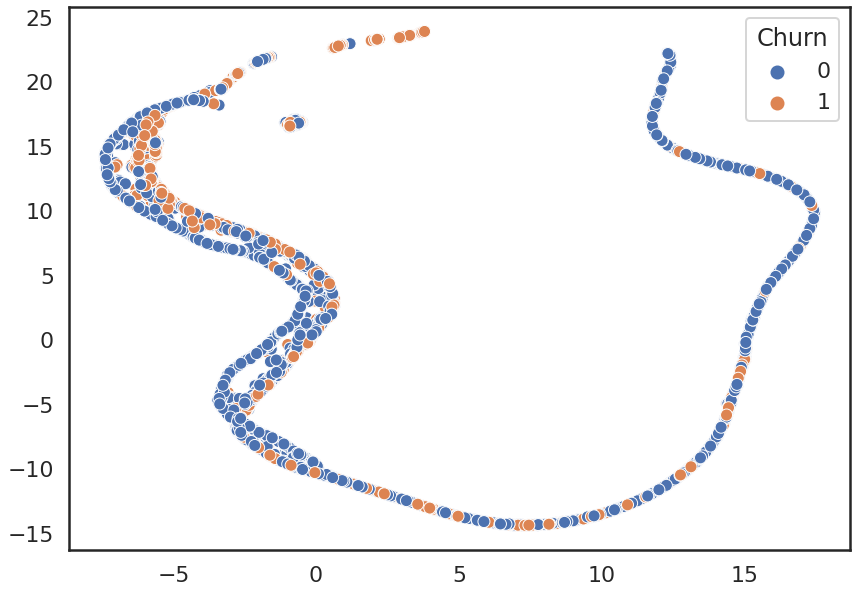

In [52]:
## Try playing around with different hyperparameters. 
## Which one(s) divides the data in a separate-able way?

fit = umap.UMAP(n_neighbors=100, metric='manhattan')
umap_reduced = fit.fit_transform(X)
sns.scatterplot(x = umap_reduced[:, 0], y=umap_reduced[:, 1], hue=y)

# K-Means

## Unsupervised Learning

So far, we handled `labeled data`: we trained classifiers to predict new labels based on existing ones. These types of tasks are called **Supervised learning**. We know in advance what the desired output is, and we try to learn a mapping function between the data and its matched labels.

Another type of learning is **Unsupervised learning**. In these tasks, we try, without any labeled examples, to find patterns in the data. 

*PCA*, *T-SNE*, and *UMAP* are examples of so-called Unsupervised Learning. We feed the data into the model - no labels are needed - and we get an output that tries to make sense of that data.

## Clustering

Another usage of unsupervised learning that can also find patterns in the data is detecting groups of similar points in our data, aka **clustering**.

An unsupervised version of K-Nearest Neighbours, called **K-Means**, does just that. Given the desired number of output groups, it calculates the distances between points and determines which ones belong together in a group or a cluster.

### How does it work?

1. First, K-Means algorithm randomly creates *k* `Centroids` in the dimensional space. 
2. In every iteration, it:
  
  I. calculates which points are the nearest to this centroid, and allocates them to it. 

  II. It then re-calculates the centroids' position, to be exactly in the middle of all the allocated points.

  III. if the centroid didn't move much, it breaks the loop and return the output.


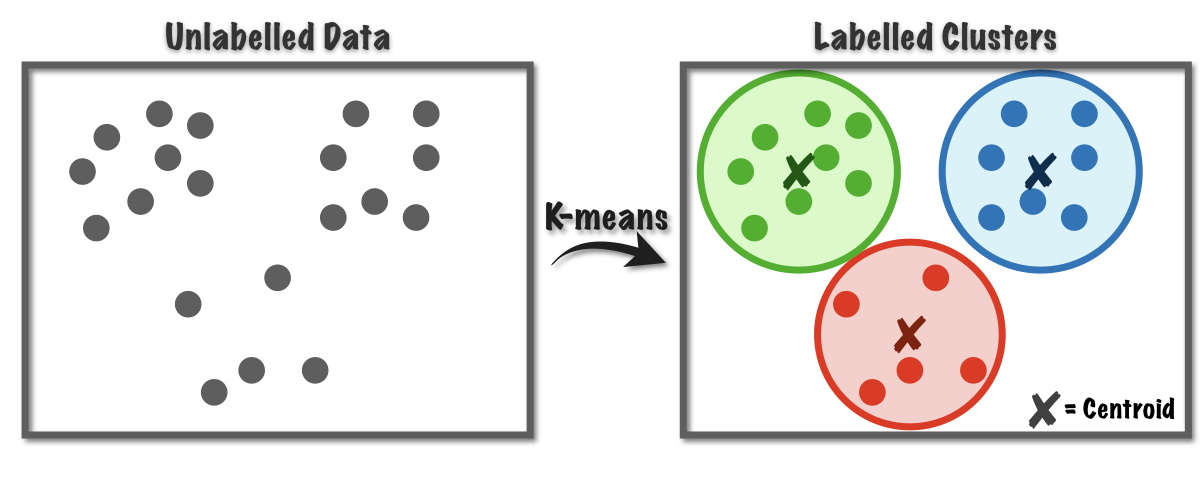

In [53]:
from sklearn.cluster import KMeans

The main question when conducting the K-Means (or clustering in general) is: How can we choose the 'right' number of clusters?

We will use a method called the **Elbow Method**

### Elbow Method 
The Elbow Method is a trial-and-error way to find the optimal number of clusters. 

We try the K-Means with a range of cluster size options, e.g., from 1 to 10, and check the score each one receives.

* We must set the 'random' initialization method for this study to reduce the effect of randomness.
* Note that the Scikit-learn K-Means algorithm has a hyperparameter - `init` - to control the initialization method. The default one - the ‘k-means++’ initialization method -  intelligently allocate the initial cluster centers (centroids) for the k-mean clustering to speed up convergence. 

In [63]:
clustering_score = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'random', random_state = 42)
    kmeans.fit(X)

    # we collect as a score the interia_ property.
    # inertia_ = Sum of squared distances of the samples to their closest cluster center.
    clustering_score.append(kmeans.inertia_) 

Plotting the score, it is clear that the line is breaking around 2-4 clusters. The distance score 'breaks' into an `elbow`. After which, we don't get much more value in dividing into more groups.

These are the points that optimize the clustering.

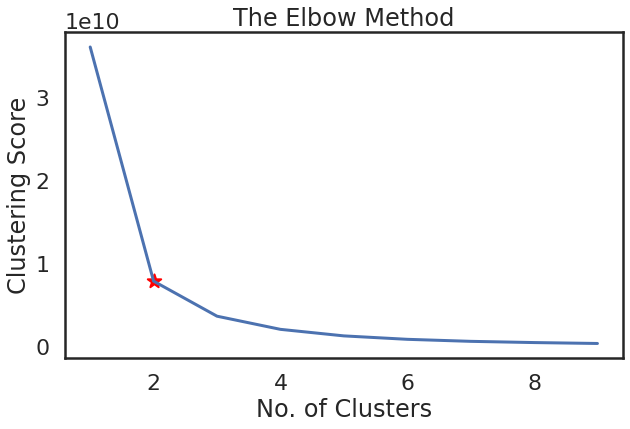

In [64]:
plt.figure(figsize=(10,6))
plt.plot(range(1, 10), clustering_score)
plt.scatter(2, clustering_score[1], s = 200, c = 'red', marker='*')
plt.title('The Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('Clustering Score')
plt.show()

Since we Do have that data, let's compare it to our known labels.

In [69]:
kmeans = KMeans(n_clusters = 2, random_state = 42)
kmeans.fit(X)

pred = kmeans.predict(X)
pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

In [70]:
print(metrics.classification_report(y, pred))

              precision    recall  f1-score   support

           0       0.69      0.66      0.67      5163
           1       0.15      0.17      0.16      1869

    accuracy                           0.53      7032
   macro avg       0.42      0.41      0.42      7032
weighted avg       0.55      0.53      0.54      7032



Also, wee can plot our predictions to compare and understand how K-Means divided our data:

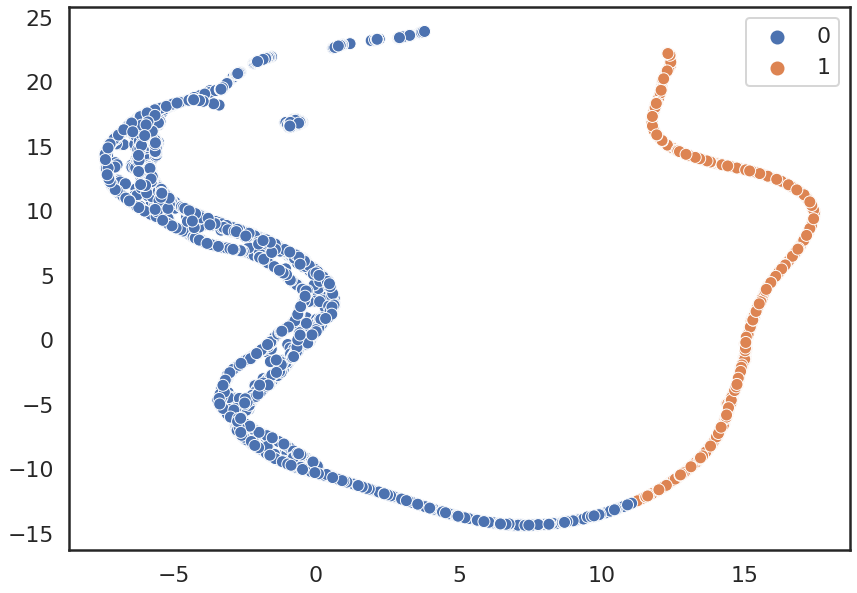

In [71]:
sns.scatterplot(x = umap_reduced[:, 0], y=umap_reduced[:, 1], hue=pred)

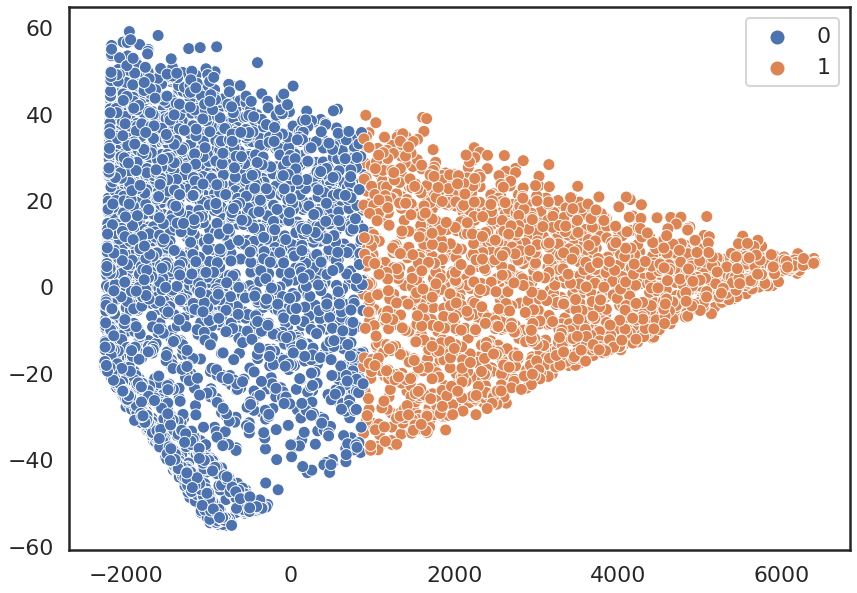

In [72]:
sns.scatterplot(x = reduced_X[:, 0], y=reduced_X[:, 1], hue=pred)

Using a `XOR` gate (in python - ^) - we can also plot which ones are correct (1) and which ones were wrong (0).

[`XOR`](https://en.wikipedia.org/wiki/Exclusive_or) is defined as:

| p | q | p ^ q|
|---|---|------|
| 0 |	0	|  0   |
| 0 |	1	|  1   |
| 1 |	0	|  1   |
| 1 |	1	|  0   |


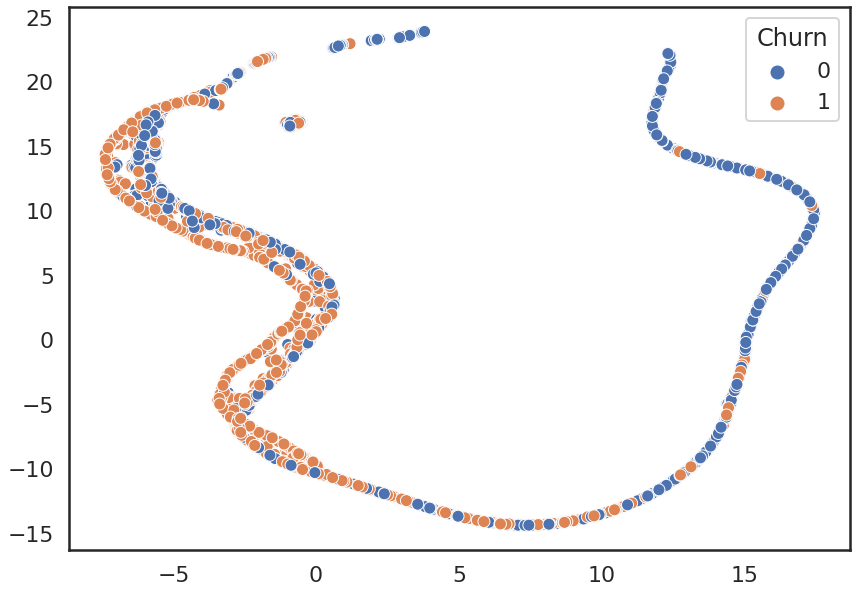

In [84]:
sns.scatterplot(x = umap_reduced[:, 0], y=umap_reduced[:, 1], hue=1 - pred ^ y)

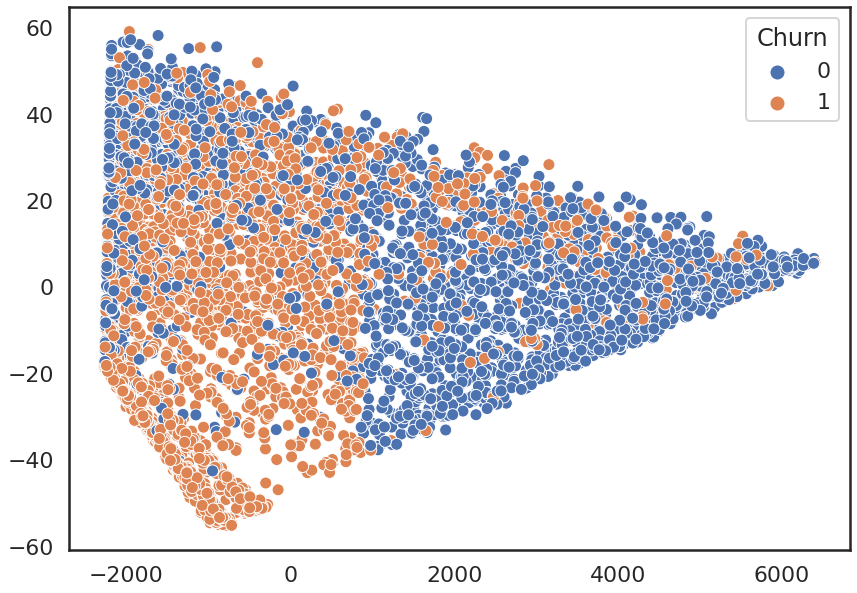

In [83]:
sns.scatterplot(x = reduced_X[:, 0], y=reduced_X[:, 1], hue=1 - pred ^ y)